In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime,timedelta
%matplotlib inline

2023-08-22 20:54:21.341486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
stock_name = "GOOG"
end_date = datetime.now()

# Format the current date as "year-month-date"
# formatted_date = cend_date.strftime('%Y-%m-%d')
start_date = "2015-01-01"
end_date  = end_date.strftime('%Y-%m-%d')

In [3]:
my_df = stock_name
df = yf.download(my_df ,start=start_date, end=end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641
...,...,...,...,...,...,...
2023-08-15,131.589996,131.990005,129.819000,130.270004,130.270004,14769200
2023-08-16,129.279999,130.897995,128.460007,129.110001,129.110001,17548400
2023-08-17,130.449997,132.490997,129.850006,130.460007,130.460007,23665600


# Plot the closing Price for the Stock

Text(0, 0.5, 'Stock price')

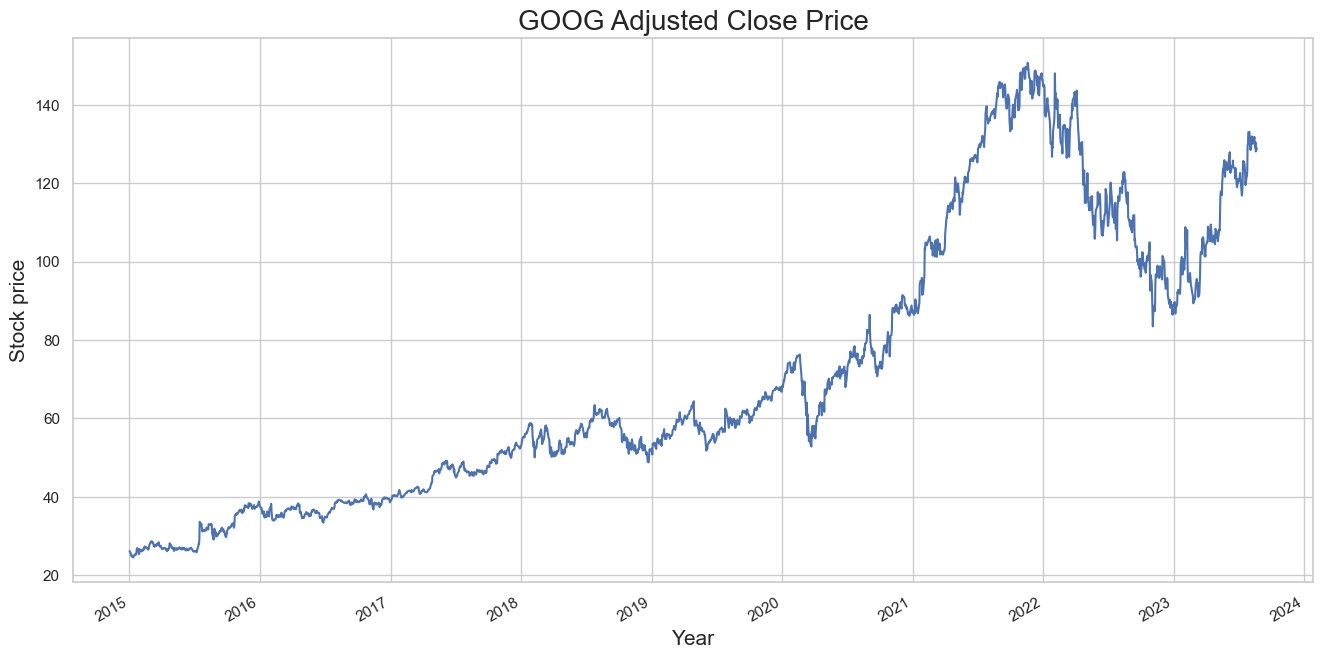

In [4]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the 'Adj Close' column from the DataFrame
df['Adj Close'].plot()

# Set plot title and labels
plt.title(f'{stock_name} Adjusted Close Price', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock price', fontsize=15)

In [5]:
# Create DataFrame for Adjusted Close price
df_adj = df[['Adj Close']]
df_adj

,Adj Close
Date,
2015-01-02,26.168653
2015-01-05,25.623152
2015-01-06,25.029282
2015-01-07,24.986401
2015-01-08,25.065184
...,...
2023-08-15,130.270004
2023-08-16,129.110001
2023-08-17,130.460007


# Creating Training Data Set and Feature Scalling

In [6]:
df_adj_arr = df_adj.values
training_data_len = int(0.8 * len(df_adj))
train = df_adj_arr[:training_data_len, :]

# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

# train_scaled

train_scaled.shape

(1738, 1)

## Split training data into X_train, y_train

In [7]:
X_train = []
y_train = []

for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)

[array([0.01275146, 0.0084272 , 0.00371951, 0.00337958, 0.00400411,
       0.00143089, 0.        , 0.00143484, 0.00328867, 0.00365231,
       0.00613857, 0.00567215, 0.01007548, 0.01653816, 0.01873587,
       0.01686228, 0.01030869, 0.00689749, 0.00715837, 0.01658955,
       0.01420212, 0.01450252, 0.01194116, 0.01384636, 0.0151982 ,
       0.01394519, 0.01754611, 0.0171627 , 0.01991378, 0.02231705,
       0.01987822, 0.01863706, 0.01989007, 0.01834061, 0.0155579 ,
       0.01721013, 0.02028535, 0.02487444, 0.02602864, 0.03114346,
       0.03205259, 0.03194586, 0.0327206 , 0.02969874, 0.03015924,
       0.02468868, 0.02317478, 0.02488631, 0.02164904, 0.02449103,
       0.02304039, 0.02646344, 0.02586659, 0.02680337, 0.0261907 ,
       0.03068889, 0.02618082, 0.02475193, 0.02205221, 0.02351077])]
[array([0.02191782])]
[array([0.01275146, 0.0084272 , 0.00371951, 0.00337958, 0.00400411,
       0.00143089, 0.        , 0.00143484, 0.00328867, 0.00365231,
       0.00613857, 0.00567215, 0.010

In [8]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1678, 60, 1)

## Train model

In [9]:
# Build the model - LSTM with 50 neurons and 4 hidden layers
model = Sequential()

# Adding the LSTM layers with Dropout regularisation
for _ in range(4):
    model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))

# Adding the final LSTM layer without return_sequences
model.add(LSTM(units=50, activation='tanh'))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the training set
model.fit(X_train, y_train, epochs=200, batch_size=64)

2023-08-22 20:54:26.135977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
27/27 [==============================] - 8s 105ms/step - loss: 0.0220
Epoch 2/200
27/27 [==============================] - 3s 106ms/step - loss: 0.0036
Epoch 3/200
27/27 [==============================] - 3s 102ms/step - loss: 0.0025
Epoch 4/200
27/27 [==============================] - 3s 105ms/step - loss: 0.0027
Epoch 5/200
27/27 [==============================] - 3s 106ms/step - loss: 0.0026
Epoch 6/200
27/27 [==============================] - 3s 106ms/step - loss: 0.0032
Epoch 7/200
27/27 [==============================] - 3s 105ms/step - loss: 0.0019
Epoch 8/200
27/27 [==============================] - 3s 105ms/step - loss: 0.0022
Epoch 9/200
27/27 [==============================] - 3s 103ms/step - loss: 0.0021
Epoch 10/200
27/27 [==============================] - 3s 105ms/step - loss: 0.0018
Epoch 11/200
27/27 [==============================] - 3s 104ms/step - loss: 0.0020
Epoch 12/200
27/27 [==============================] - 3s 103ms/step - loss: 0.0019
Epoch 13/200


27/27 [==============================] - 3s 101ms/step - loss: 7.9915e-04
Epoch 99/200
27/27 [==============================] - 3s 104ms/step - loss: 7.8237e-04
Epoch 100/200
27/27 [==============================] - 3s 100ms/step - loss: 7.5289e-04
Epoch 101/200
27/27 [==============================] - 3s 101ms/step - loss: 8.7018e-04
Epoch 102/200
27/27 [==============================] - 3s 102ms/step - loss: 7.2275e-04
Epoch 103/200
27/27 [==============================] - 3s 102ms/step - loss: 7.0968e-04
Epoch 104/200
27/27 [==============================] - 3s 103ms/step - loss: 7.9335e-04
Epoch 105/200
27/27 [==============================] - 3s 104ms/step - loss: 7.8113e-04
Epoch 106/200
27/27 [==============================] - 3s 100ms/step - loss: 0.0011
Epoch 107/200
27/27 [==============================] - 3s 104ms/step - loss: 7.7348e-04
Epoch 108/200
27/27 [==============================] - 3s 104ms/step - loss: 7.1559e-04
Epoch 109/200
27/27 [==============================

27/27 [==============================] - 3s 100ms/step - loss: 5.4593e-04
Epoch 192/200
27/27 [==============================] - 3s 101ms/step - loss: 5.5363e-04
Epoch 193/200
27/27 [==============================] - 3s 103ms/step - loss: 6.0219e-04
Epoch 194/200
27/27 [==============================] - 3s 101ms/step - loss: 6.3576e-04
Epoch 195/200
27/27 [==============================] - 3s 103ms/step - loss: 6.4597e-04
Epoch 196/200
27/27 [==============================] - 3s 107ms/step - loss: 6.2641e-04
Epoch 197/200
27/27 [==============================] - 3s 105ms/step - loss: 6.4949e-04
Epoch 198/200
27/27 [==============================] - 3s 103ms/step - loss: 5.8507e-04
Epoch 199/200
27/27 [==============================] - 3s 99ms/step - loss: 6.1668e-04
Epoch 200/200
27/27 [==============================] - 3s 110ms/step - loss: 5.5659e-04


In [16]:
test = df_adj_arr[training_data_len: , :]
inputs = df_adj_arr[len(df_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1, 1)

# Scaling the data
inputs = scaler.transform(inputs)

# Initialize lists for X_test and y_test
X_test = []
y_test = df_adj_arr[training_data_len:, :]

# Create sequences of length 60 for X_test
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i - 60:i, 0])

In [17]:
# Convert data to numpy array
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # 3D
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

14/14 [==============================] - 1s 23ms/step


 ## RMSE

In [18]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

1.9723177504265446

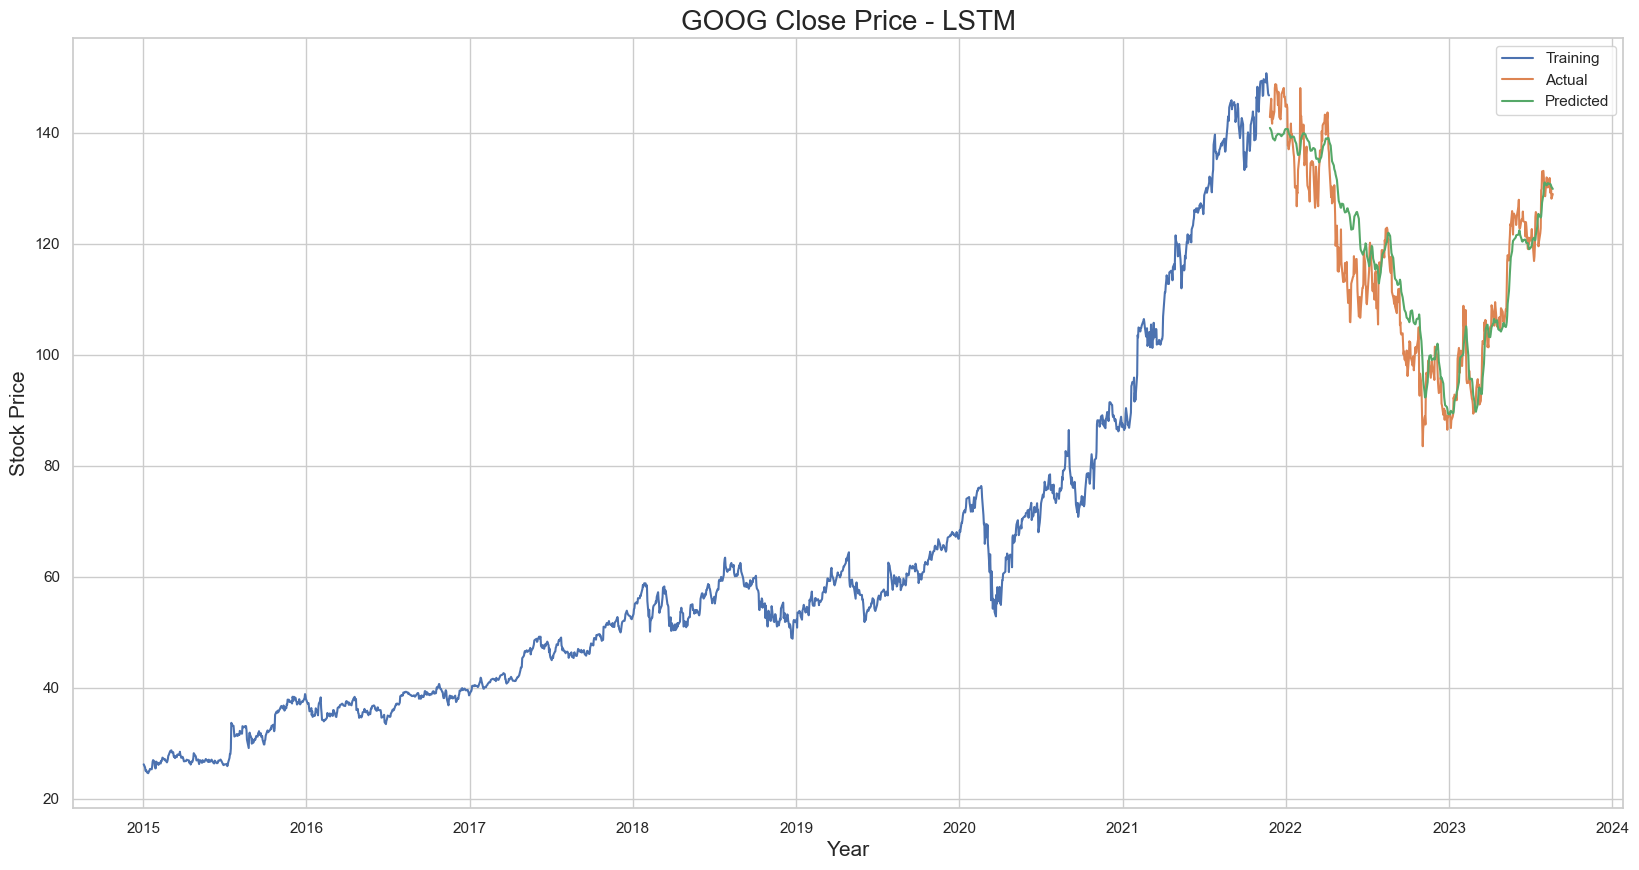

In [19]:
# Plot predicted vs actual values
train = df_adj[:training_data_len]
test = df_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')

plt.title("GOOG Close Price - LSTM", fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.legend()

plt.show()


In [20]:
test

,Adj Close,Predictions
Date,,
2021-11-26,142.806000,140.855774
2021-11-29,146.113998,140.407501
2021-11-30,142.451996,140.052597
2021-12-01,141.617996,139.668732
2021-12-02,143.776505,139.223816
...,...,...
2023-08-15,130.270004,130.765289
2023-08-16,129.110001,130.701965
2023-08-17,130.460007,130.440781


## Adjusted Closing Price Prediction

In [26]:
# Predict Adjusted Close price for AZN stock for 11 Jul 2019   
# get the quote
curr_stock = stock_name + "L"
df_quote = yf.download(curr_stock, start=start_date, end=end_date)
# Create new df
new_df = df_quote.filter(['Adj Close'])
# Get last 60 days closing price and convert df to array])
prev_days = new_df[-60:].values
# Scale data to be values between 0 and 1
prev_days_scaled = scaler.transform(prev_days)
# Create empty list
X_test = []
# Append last 60 days 
X_test.append(prev_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)
     

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 26ms/step
[[128.96121]]


In [27]:
# Actual price
# Get today's date
today = datetime.today()

# Calculate the previous day's date
previous_day = today - timedelta(days=1)

actual_price = yf.download("AZN.L", start=previous_day, end=end_date)
print(actual_price['Adj Close'])

[*********************100%%**********************]  1 of 1 completed
Date
2023-08-21    10674.0
Name: Adj Close, dtype: float64
